# Import Libraries

In [199]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
import numpy as np
import logging, os

# TensorFlow Version and GPU Availability

In [200]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available: 1


# Define Hyperparameters

In [201]:
ImageSize = 256
BatchSize = 32
CHANNELS = 3
epochs = 100

# Load Dataset and Class Names

In [202]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(ImageSize, ImageSize),
    batch_size=BatchSize
)

class_names = dataset.class_names


Found 2152 files belonging to 3 classes.


# Visualize Sample Images from Dataset

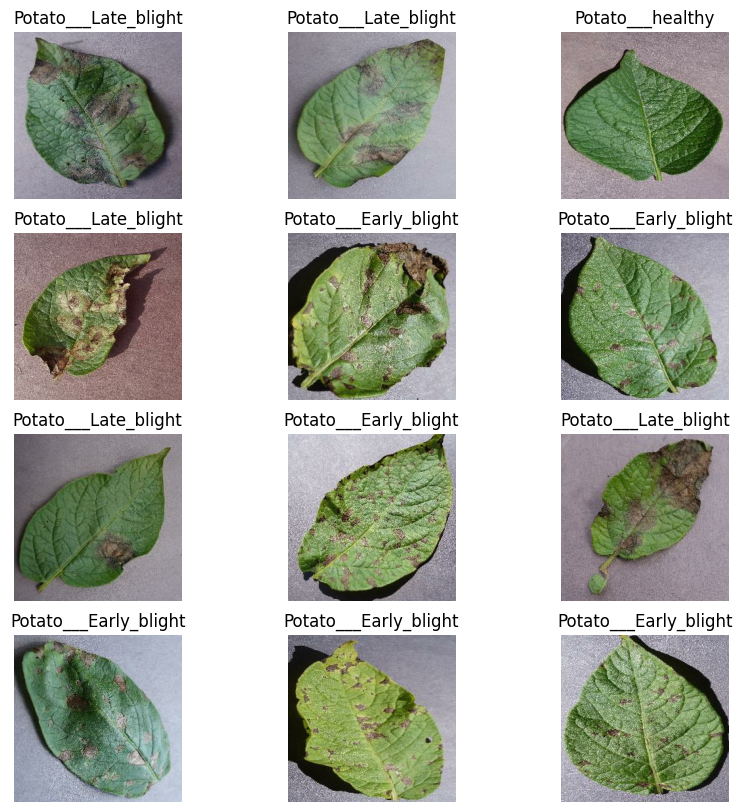

In [203]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


# Split Dataset into Train, Validation, and Test Sets

In [204]:
def data_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = data_split(dataset)




# Optimize Dataset Performance with Caching, Shuffling, and Prefetching

In [205]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing and Augmentation Layers

In [206]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Define Input Shape and Number of Classes

In [207]:
input_shape = (BatchSize, ImageSize, ImageSize, CHANNELS)
n_classes = len(class_names)

# Build CNN Model with Regularization and Dropout

In [208]:
from tensorflow.keras import regularizers

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001),  # ← L2
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)), # ← L2
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)), # ← L2
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)), # ← L2
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)), # ← L2
    layers.Dropout(0.5),

    layers.Dense(n_classes, activation='softmax')
])


# Compile the CNN Model

In [209]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define Early Stopping Callback

In [210]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
    ,
    restore_best_weights=True
)

# Train the Model with Early Stopping

In [211]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=BatchSize,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
54/54 [==============================] - 16s 223ms/step - loss: 1.5020 - accuracy: 0.5116 - val_loss: 1.2998 - val_accuracy: 0.7188
Epoch 2/100
54/54 [==============================] - 11s 206ms/step - loss: 1.0783 - accuracy: 0.6794 - val_loss: 0.8004 - val_accuracy: 0.8385
Epoch 3/100
54/54 [==============================] - 11s 206ms/step - loss: 0.8221 - accuracy: 0.7853 - val_loss: 0.6400 - val_accuracy: 0.8802
Epoch 4/100
54/54 [==============================] - 11s 210ms/step - loss: 0.7167 - accuracy: 0.8119 - val_loss: 0.4820 - val_accuracy: 0.9115
Epoch 5/100
54/54 [==============================] - 11s 211ms/step - loss: 0.6054 - accuracy: 0.8466 - val_loss: 0.4560 - val_accuracy: 0.8698
Epoch 6/100
54/54 [==============================] - 11s 208ms/step - loss: 0.5431 - accuracy: 0.8611 - val_loss: 0.4484 - val_accuracy: 0.8802
Epoch 7/100
54/54 [==============================] - 11s 209ms/step - loss: 0.4696 - accuracy: 0.8900 - val_loss: 0.4524 - val_accuracy:

# Plot Training and Validation Accuracy & Loss

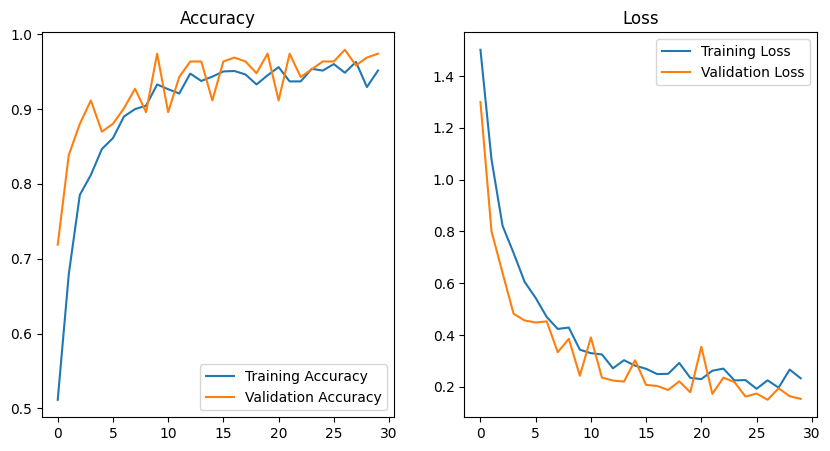

In [212]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Define Prediction Function

In [213]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Test Model on a Sample Image from Test Set

Actual Label: Potato___Early_blight
1/1 [==============================] - 0s 81ms/step
Predicted Label: Potato___Early_blight


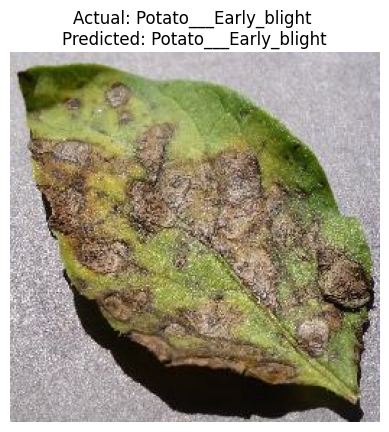

In [214]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("Actual Label:", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

    plt.imshow(first_image)
    plt.title(f"Actual: {class_names[first_label]} \nPredicted: {class_names[np.argmax(batch_prediction[0])]}")
    plt.axis("off")
    plt.show()


# Visualize Predictions on Multiple Test Images

1/1 [==============================] - 0s 16ms/step


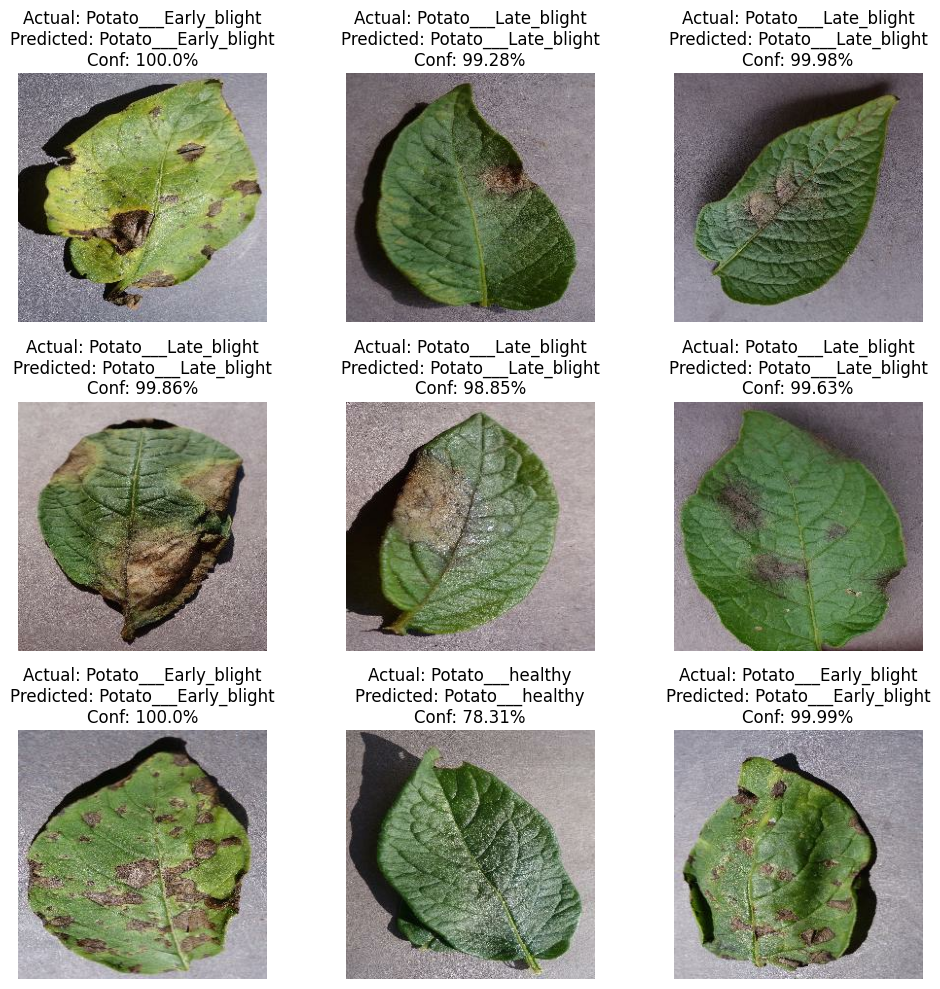

In [215]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        predicted_class, confidence = predict(model, img)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConf: {confidence}%")
        plt.axis("off")

plt.tight_layout()
plt.show()



# Save the Trained Model

In [216]:
save_dir = r"D:\CNN-Potato-Disease\My-App"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "model.h5")

model.save(save_path)

print(f"✅ Model saved successfully to: {save_path}")


✅ Model saved successfully to: D:\CNN-Potato-Disease\My-App\model.h5
